In [2]:
!pip install augraphy albumentations tqdm

  Obtaining dependency information for augraphy from https://files.pythonhosted.org/packages/54/56/ac891bb8bca373d3786ee321a1308d2ccd442ec84abe294be0a41ab8a335/augraphy-8.2.6-py3-none-any.whl.metadata
  Obtaining dependency information for numba>=0.57.0 from https://files.pythonhosted.org/packages/79/58/cb4ac5b8f7ec64200460aef1fed88258fb872ceef504ab1f989d2ff0f684/numba-0.60.0-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata
  Obtaining dependency information for opencv-python>=4.5.1.48 from https://files.pythonhosted.org/packages/3f/a4/d2537f47fd7fcfba966bd806e3ec18e7ee1681056d4b0a9c8d983983e4d5/opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for llvmlite<0.44,>=0.43.0dev0 from https://files.pythonhosted.org/packages/c6/21/2ffbab5714e72f2483207b4a1de79b2eecd9debbf666ff4e7067bcc5c134/llvmlite-0.43.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

from sklearn.model_selection import KFold
from augraphy import *
from glob import glob
import cv2

In [2]:
# 데이터 경로 설정
input_dir = "/data/ephemeral/home/data/train"
output_dir = "/data/ephemeral/home/data/aug_img"
csv_input_path = "/data/ephemeral/home/data/train.csv"
csv_output_path = "/data/ephemeral/home/data/aug_img.csv"

In [3]:
# 출력 디렉토리 생성
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [4]:
# 1번 처리 : augraphy
paper_phase = [

    ColorPaper(
        hue_range=(0, 255),
        saturation_range=(10, 40),
        p=0.33,
    ),
            OneOf(
        [
            DelaunayTessellation(
                n_points_range=(500, 800),
                n_horizontal_points_range=(500, 800),
                n_vertical_points_range=(500, 800),
                noise_type="random",
                color_list="default",
                color_list_alternate="default",
            ),
            PatternGenerator(
                imgx=random.randint(256, 512),
                imgy=random.randint(256, 512),
                n_rotation_range=(10, 15),
                color="random",
                alpha_range=(0.25, 0.5),
            ),
            VoronoiTessellation(
                mult_range=(50, 80),
                seed=19829813472,
                num_cells_range=(500, 1000),
                noise_type="random",
                background_value=(200, 255),
            ),
        ],
        p=1.0,
    ),
    AugmentationSequence(
        [
            NoiseTexturize(
                sigma_range=(3, 10),
                turbulence_range=(2, 5),
            ),
            BrightnessTexturize(
                texturize_range=(0.9, 0.99),
                deviation=0.03,
            ),
        ],
    ),
]

post_phase = [
    VoronoiTessellation(p=0.7),
]
augr1 = AugraphyPipeline(paper_phase=paper_phase, post_phase=post_phase)


# albumentation
alb1 = A.Compose([
    A.HorizontalFlip(p=0.8),
    A.VerticalFlip(p=0.8),
    A.Rotate(p=0.8),
    A.Resize(224, 224)
])


In [5]:
#2번 처리
# output_folder = "/data/ephemeral/home/data/aug_img"

# augraphy
ink_phase = [
    Folding(p=0.6)
    ]

paper_phase = [
    ColorPaper(p=0.6),
    ColorShift(p=0.6),
    ReflectedLight(p=0.6)
]

post_phase = [
    VoronoiTessellation(p=0.6),
]
pipeline = AugraphyPipeline(ink_phase=ink_phase, paper_phase=paper_phase, post_phase=post_phase)

augr2_5team = pipeline

# albumentation
alb2_5team = A.Compose([
    A.HorizontalFlip(p=0.6),
    A.VerticalFlip(p=0.6),
    A.Rotate(p=0.6),
    A.GaussianBlur(p=0.6),
    A.RandomBrightnessContrast(p=0.6),
    A.HueSaturationValue(p=0.6),
    A.RandomGamma(p=0.6),
    A.ColorJitter(p=0.6),
    A.CoarseDropout(p=0.6),
    A.GaussNoise(p=0.6),
    A.Resize(224, 224),
    #ToTensorV2()
])


In [6]:
# 3 증강 - 한아름

# Augraphy 증강 파이프라인 설정 (잉크 낙서 효과 제외)
han_augr = AugraphyPipeline([
    LightingGradient(p=0.5),   # 조명 그라디언트를 추가하여 문서나 페이지의 일부가 더 밝거나 어둡게 보임 
    SubtleNoise(p=0.5),   # 페이지에 미세한 노이즈를 추가하여 약간의 텍스처를 더함 
    BrightnessTexturize(p=0.5),   # 텍스처를 추가하면서 밝기를 조절
    PageBorder(p=0.5),   # 페이지에 테두리를 추가
])

# Albumentations 증강 파이프라인 설정
han_alb_aug = A.Compose([
    A.Rotate(limit=360, p=0.7),  # 회전: 'limit=45' 회전 각도의 최대치, 'p=0.5' 이 변환이 50% 확률로 적용됨 
    A.GaussNoise(var_limit=(1.0, 10.0), p=0.5),  # 노이즈 추가 (강도 줄임)
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # 밝기 및 대조 조절
    A.RandomResizedCrop(height=256, width=256, scale=(0.95, 1), ratio=(0.95, 1.05), p=0.7)  # 랜덤 크기로 조정 및 자르기
])


In [7]:
# 증강 4 - 2024.8.8
alb_add = A.Compose([
    A.OneOf([
        A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=(255, 255, 255), mask_value=None, always_apply=True, p=1),
        A.ElasticTransform(always_apply=True, p=1, alpha=1.0, sigma=50.0, alpha_affine=50.0, interpolation=0, border_mode=1, value=(255, 255, 255), mask_value=None, approximate=False),
        A.OpticalDistortion(always_apply=True, p=1, distort_limit=(-0.3, -0.1)),
        A.OpticalDistortion(always_apply=True, p=1, distort_limit=(0.1, 0.3)),
    ], p=0.5),
    A.SomeOf([
        A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=1),
        A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=25, val_shift_limit=20, p=1),
        A.MultiplicativeNoise(p=1, multiplier=(1, 1.5), per_channel=False),
        A.Equalize(p=1, mode='cv', by_channels=False),
    ], n=2, p=0.4),
    A.CoarseDropout(p=0.4, max_holes=40, max_height=15, max_width=15, min_holes=8, min_height=8, min_width=8),
    A.OneOf([
        A.Blur(blur_limit=(3, 4), p=1),
        A.MotionBlur(blur_limit=(3, 5), p=1),
        A.Downscale(scale_min=0.455, scale_max=0.5, interpolation=2, p=1),
    ], p=0.5),
    A.GaussNoise(var_limit=(400, 1300), per_channel=False, p=0.5),
])


In [7]:
# 데이터 경로 설정
input_dir = "/data/ephemeral/home/data/train"
output_dir = "/data/ephemeral/home/data/aug_img"
csv_input_path = "/data/ephemeral/home/data/train.csv"
csv_output_path = "/data/ephemeral/home/data/aug_img.csv"

증강처리 함수




In [11]:

def aug_processing(input_dir, output_dir, csv_input_path, csv_output_path, augr, alb, th, aug_nums, chk):
    # CSV 파일 로드
    df = pd.read_csv(csv_input_path)

    # CSV 파일에 저장할 데이터 리스트 초기화
    csv_data = []

    ## aug
    albumentations_aug = alb
    pipeline_aug = augr

    # 이미지 증강 및 저장
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        filename = row['ID']  # 'ID' 컬럼에서 파일명 추출
        target = row['target']  # 'target' 컬럼에서 클래스 추출
        
        # 이미지 경로 설정
        image_path = os.path.join(input_dir, filename)
        if not os.path.exists(image_path):
            continue
        
        # 이미지 로드
        image = cv2.imread(image_path)

        # 각 이미지에 대해 여러개의 증강 이미지 생성
        for i in range(aug_nums):
            
            if chk != 'pass':
                # Albumentations 증강 적용
                albumentations_image = albumentations_aug(image=image)['image']

                # Augraphy 증강 적용
                augraphy_image = pipeline_aug(albumentations_image)
            else : 
                # Albumentations 증강 적용
                augraphy_image = albumentations_aug(image=image)['image']

            # 증강된 이미지 저장
            combined_output_path = os.path.join(output_dir, f"combined{th}_{i}_{filename}")

            cv2.imwrite(combined_output_path, augraphy_image)

            # CSV 데이터 추가
            csv_data.append([f"combined{th}_{i}_{filename}", target])

    # 증강된 이미지 정보가 담긴 데이터프레임 생성 및 CSV 파일로 저장
    augmented_df = pd.DataFrame(csv_data, columns=['ID', 'target'])
    augmented_df.to_csv(csv_output_path, index=False)

    # CSV 파일로 저장
    df = pd.DataFrame(csv_data, columns=["ID", "target"])
    df.to_csv(os.path.join(csv_output_path), index=False)

    print("이미지 증강 및 CSV 저장이 완료되었습니다.")


In [9]:
aug_multi_nums = 20

In [ ]:
# # 1차 증강
# aug_processing(input_dir, output_dir, csv_input_path, csv_output_path, augr1, alb1, 1, aug_multi_nums)

In [3]:
# aug_df = pd.read_csv("data/aug_img.csv")

In [5]:
# len(aug_df)
# # aug_df.head(10)

15700

In [ ]:
# # 2차 증강
# csv_output_path2 = "/data/ephemeral/home/data/aug_img2.csv"

# aug_processing(input_dir, output_dir, csv_input_path, csv_output_path2, augr2_5team, alb2_5team, 2, aug_multi_nums)

100%|██████████| 1570/1570 [58:22<00:00,  2.23s/it] 

이미지 증강 및 CSV 저장이 완료되었습니다.


In [11]:
# 3차 증강 - 새로 추가된 이부분만 실행해보자(1차 2차 이미 만들었으므로 제외)
# csv_output_path3 = "/data/ephemeral/home/data/aug_img3.csv"

# aug_processing(input_dir, output_dir, csv_input_path, csv_output_path3, han_augr, han_alb_aug, 3, aug_multi_nums)

100%|██████████| 1570/1570 [16:03<00:00,  1.63it/s]

이미지 증강 및 CSV 저장이 완료되었습니다.


In [12]:
# 4차 증강 - 새로 추가 2024.8.8
csv_output_path4 = "/data/ephemeral/home/data/aug_img4.csv"

aug_processing(input_dir, output_dir, csv_input_path, csv_output_path4, han_augr, alb_add, 4, aug_multi_nums, 'pass')

100%|██████████| 1570/1570 [15:08<00:00,  1.73it/s]

이미지 증강 및 CSV 저장이 완료되었습니다.


In [13]:
aug_df = pd.read_csv("data/aug_img4.csv")
len(aug_df)

31400

In [14]:
aug_df.head()

ID  target
0  combined4_0_002f99746285dfdd.jpg      16
1  combined4_1_002f99746285dfdd.jpg      16
2  combined4_2_002f99746285dfdd.jpg      16
3  combined4_3_002f99746285dfdd.jpg      16
4  combined4_4_002f99746285dfdd.jpg      16

증강이미지 시각화

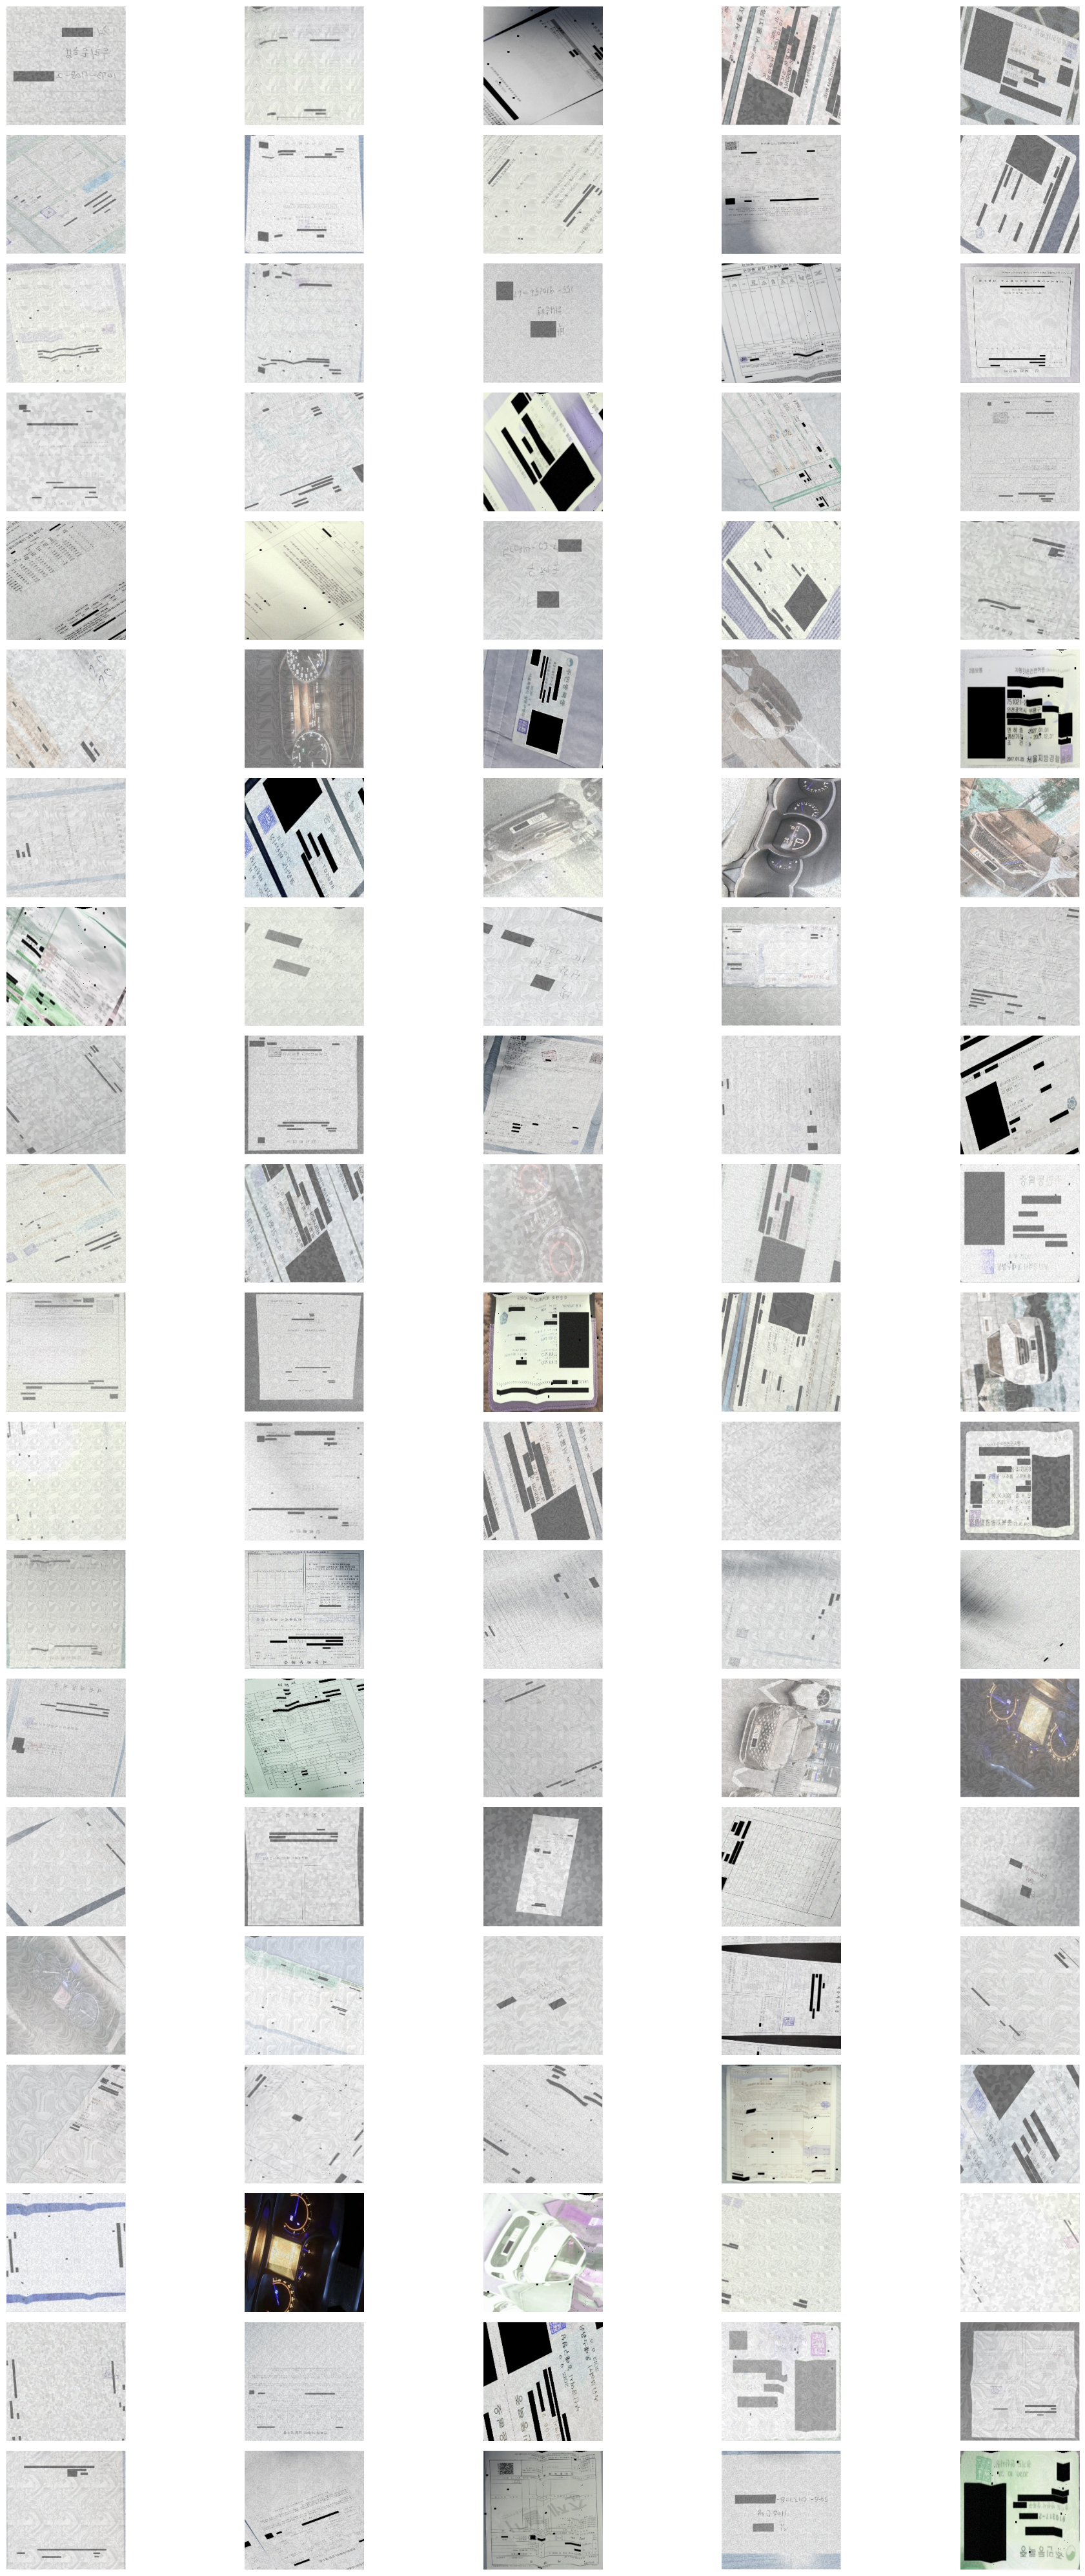

In [21]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# 데이터 경로 설정
output_dir = "/data/ephemeral/home/data/aug_img"

# 증강된 이미지 파일 목록 불러오기
image_files = [os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith((".jpg", ".jpeg", ".png"))]

# 랜덤으로 100개 이미지 선택
selected_images = random.sample(image_files, 100)

# 20x5 그리드로 시각화
fig, axes = plt.subplots(20, 5, figsize=(20, 40))

for ax, img_path in zip(axes.flatten(), selected_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 형식이므로 RGB로 변환
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [22]:
# 원본이미지를 증강이미지 폴더에 복사
!cp -r /data/ephemeral/home/data/train/* /data/ephemeral/home/data/aug_img